In [2]:
#!pip install lifetimes

import pandas as pd
import numpy as np
import datetime as dt
import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 500)

In [3]:
df = pd.read_csv("../Datasets/marketing_campaign.csv", sep="\t")
df_ = df.copy()
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.00,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.00,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.00,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.00,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.00,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [4]:
def check_df(dataframe, head=2):
    print('\033[1m' + '############ Shape ############' + '\033[0m')
    print(dataframe.shape)
    print('\033[1m' + '############ Types ############' + '\033[0m')
    print(dataframe.dtypes)
    print('\033[1m' + '############ Unique Values ############' + '\033[0m')
    print(dataframe.nunique())
    print('\033[1m' + '############ NA ############' + '\033[0m')
    print(dataframe.isnull().sum())
    print('\033[1m' + '############ Quantiles ############' + '\033[0m')
    print(dataframe.describe([0, 0.25, 0.50, 0.75, 0.99, 1]).T)

check_df(df)

############ Shape ############
(2240, 29)
############ Types ############
ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object
############

In [5]:
df['Income'] = df['Income'].fillna(df['Income'].median()) # Filling the missing values on 'Income' with a median value

In [6]:
# outlier_thresholds and replace_with_thresholds functions are defined to suppress outliers.

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit, 0)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit, 0)

In [7]:
columns = ["MntWines", "MntFruits", "MntMeatProducts","MntFishProducts", "MntSweetProducts", "MntGoldProds", "NumDealsPurchases", "NumWebPurchases",
           "NumCatalogPurchases", "NumStorePurchases", "Income"]

for col in columns:
    replace_with_thresholds(df, col)

In [8]:
df["customer_value_total"] = df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] + df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]

df["order_num_total"] = df["NumDealsPurchases"] + df["NumWebPurchases"] + df["NumCatalogPurchases"] + df["NumStorePurchases"]

df = df[["ID", "Year_Birth", "Education", "Marital_Status", "Income", "Kidhome", "Teenhome", "Dt_Customer", "Recency", "customer_value_total", "order_num_total"]] # Drop the combined values from the dataset.

df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,customer_value_total,order_num_total
0,5524,1957,Graduation,Single,58138.00,0,0,04-09-2012,58,1617,25
1,2174,1954,Graduation,Single,46344.00,1,1,08-03-2014,38,27,6
2,4141,1965,Graduation,Together,71613.00,0,0,21-08-2013,26,776,21
3,6182,1984,Graduation,Together,26646.00,1,0,10-02-2014,26,53,8
4,5324,1981,PhD,Married,58293.00,1,0,19-01-2014,94,422,19


In [9]:
df = df[(df['order_num_total'] > 1) & (df['customer_value_total'] > 1)] # Filtering order_num_total and customer_value_total are greater than 1.

In [10]:
rfm = pd.DataFrame()
rfm["customer_id"] = df["ID"]
rfm["recency"] = df["Recency"]
rfm["frequency"] = df["order_num_total"]
rfm["monetary"] = df["customer_value_total"]

rfm.head()

,customer_id,recency,frequency,monetary
0,5524,58,25,1617
1,2174,38,6,27
2,4141,26,21,776
3,6182,26,8,53
4,5324,94,19,422


In [11]:
# recency_score, frequency_score, monetary_score

rfm["recency_score"] = pd.qcut(rfm['recency'].rank(method="first"), 5, labels=[5, 4, 3, 2, 1])
rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm["monetary_score"] = pd.qcut(rfm['monetary'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

# RF_SCORE

rfm["RF_SCORE"] = (rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str))

rfm.head()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RF_SCORE
0,5524,58,25,1617,3,5,5,35
1,2174,38,6,27,4,1,1,41
2,4141,26,21,776,4,4,4,44
3,6182,26,8,53,4,2,1,42
4,5324,94,19,422,1,4,3,14


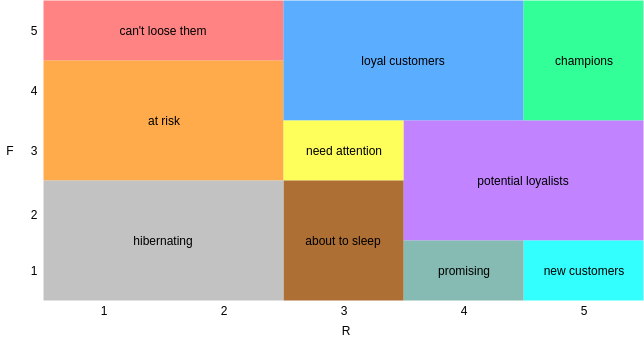

In [12]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

rfm['segment'] = rfm['RF_SCORE'].replace(seg_map, regex=True)
rfm.head()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RF_SCORE,segment
0,5524,58,25,1617,3,5,5,35,loyal_customers
1,2174,38,6,27,4,1,1,41,promising
2,4141,26,21,776,4,4,4,44,loyal_customers
3,6182,26,8,53,4,2,1,42,potential_loyalists
4,5324,94,19,422,1,4,3,14,at_Risk


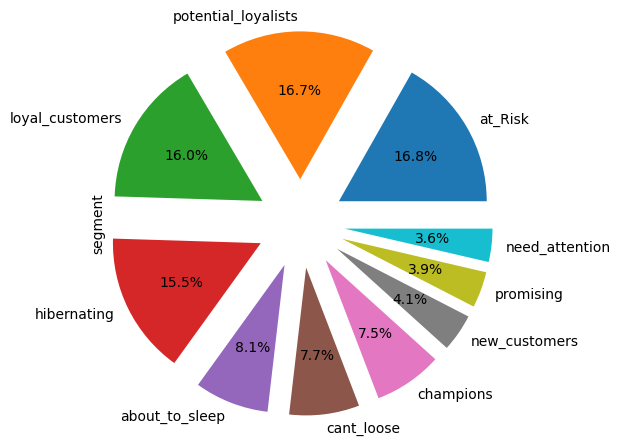

In [13]:
# Visualized to see percentages of segments

rfm["segment"].value_counts().plot.pie(subplots=True, autopct='%1.1f%%', explode=[0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3])
plt.show()

In [14]:
df_c = df # Saving df as df_c to restore if data gets corrupted during operations.
df_c["Dt_Customer"] = df_c["Dt_Customer"].apply(pd.to_datetime) # Converting date variable's datatype to datetime.

# Recency: The age of the customer when he made its last purchase (Last customer purchase date - first customer purchase date)
# T: Customer's age. (how long before the analysis date the first purchase was made)
# Frequency: The number of repeated purchases the customer made after his first date of first purchase
# Average Monetary: The average amount spent by a customer

cltv_df = pd.DataFrame()
cltv_df["customer_id"] = df_c["ID"]
cltv_df["recency_cltv_weekly"] = df_c["Recency"] /7  # Expression of recency and T for BGNBD in weekly terms
cltv_df["T_weekly"] = ((df['Dt_Customer'].max() - df['Dt_Customer']).dt.days / 7 ) + 20
cltv_df["frequency"] = df_c["order_num_total"]
cltv_df["monetary_cltv_avg"] = df_c["customer_value_total"] / df_c["order_num_total"] # Expressing monetary value as average earnings per purchase

cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg
0,5524,8.29,158.71,25,64.68
1,2174,5.43,37.86,6,4.50
2,4141,3.71,87.43,21,36.95
3,6182,3.71,29.29,8,6.62
4,5324,13.43,65.86,19,22.21


In [15]:
# 1. Preparation of the BGNBD model

bgf = BetaGeoFitter(penalizer_coef=0.0001)
bgf.fit(cltv_df['frequency'],
        cltv_df['recency_cltv_weekly'],
        cltv_df['T_weekly'])

# Estimate expected purchases from customers in 3 months and add exp_sales_3_month to cltv dataframe.

cltv_df["exp_sales_3_month"] = bgf.predict(4*3,
                                       cltv_df['frequency'],
                                       cltv_df['recency_cltv_weekly'],
                                       cltv_df['T_weekly'])

# Estimate expected purchases from customers in 6 months and add exp_sales_6_month to cltv dataframe.

cltv_df["exp_sales_6_month"] = bgf.predict(4*6,
                                       cltv_df['frequency'],
                                       cltv_df['recency_cltv_weekly'],
                                       cltv_df['T_weekly'])

# 2.  Fit the Gamma-Gamma model. Estimate the average value of the customers and add it to the cltv dataframe as exp_average_value.

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])
cltv_df["exp_average_value"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                cltv_df['monetary_cltv_avg'])
cltv_df.head()

# 3. Calculate 6 months CLTV and add it to the dataframe with the name cltv.

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency_cltv_weekly'],
                                   cltv_df['T_weekly'],
                                   cltv_df['monetary_cltv_avg'],
                                   time=6,
                                   freq="W",
                                   discount_rate=0.01)
cltv_df["cltv"] = cltv

In [16]:
# 1. Divide all your customers into 4 groups (segments) according to 6-month CLTV and add the group names to the dataset. Assign it with the name cltv_segment.

cltv_df["cltv_segment"] = pd.qcut(cltv_df["cltv"], 4, labels=["D", "C", "B", "A"])
cltv_df = cltv_df.sort_values(by="cltv", ascending=False)
cltv_df.reset_index(inplace=True, drop=True)
cltv_df.head(10)

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv,cltv_segment
0,2986,12.71,20.43,4,5.00,1.38,2.50,5.84,15.09,A
1,1755,13.29,24.57,7,16.29,0.37,0.66,16.85,11.50,A
2,8146,12.00,24.43,5,10.80,0.48,0.87,11.53,10.36,A
3,8595,14.14,24.86,7,9.57,0.51,0.91,10.08,9.48,A
4,7232,14.14,24.86,7,9.57,0.51,0.91,10.08,9.48,A
5,5899,9.71,58.29,2,24.50,0.05,0.11,26.72,2.94,A
6,4345,7.00,20.71,4,5.25,0.19,0.35,6.09,2.19,A
7,231,12.29,24.71,7,4.57,0.21,0.37,5.04,1.93,A
8,4066,10.86,24.43,7,6.57,0.09,0.17,7.06,1.22,A
9,10022,11.14,33.57,4,4.00,0.11,0.21,4.82,1.07,A


In [17]:
cltv_final = cltv_df.merge(rfm, on="customer_id", how="left")
cltv_final.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency_x,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv,cltv_segment,recency,frequency_y,monetary,recency_score,frequency_score,monetary_score,RF_SCORE,segment
0,2986,12.71,20.43,4,5.00,1.38,2.50,5.84,15.09,A,89,4,20,1,1,1,11,hibernating
1,1755,13.29,24.57,7,16.29,0.37,0.66,16.85,11.50,A,93,7,114,1,1,2,11,hibernating
2,8146,12.00,24.43,5,10.80,0.48,0.87,11.53,10.36,A,84,5,54,1,1,1,11,hibernating
3,8595,14.14,24.86,7,9.57,0.51,0.91,10.08,9.48,A,99,7,67,1,1,2,11,hibernating
4,7232,14.14,24.86,7,9.57,0.51,0.91,10.08,9.48,A,99,7,67,1,1,2,11,hibernating


In [18]:
# Group df by segment and check the mean and total values of the variables.

cltv_final[["segment", "recency_cltv_weekly","frequency_x","T_weekly","monetary_cltv_avg","exp_average_value"]].groupby("segment").agg(
    {"count", "mean"})

recency_cltv_weekly       frequency_x       T_weekly        monetary_cltv_avg       exp_average_value      
                                  count  mean       count  mean    count   mean             count  mean             count  mean
segment                                                                                                                        
about_to_sleep                      181  6.98         181  6.94      181  86.70               181  9.43               181  9.99
at_Risk                             375 11.21         375 17.38      375  96.63               375 48.90               375 49.23
cant_loose                          171 11.32         171 25.77      171 103.50               171 47.12               171 47.34
champions                           167  1.29         167 22.95      167  96.58               167 47.30               167 47.55
hibernating                         347 11.42         347  7.10      347  87.77               347 10.64               347 11.19
loyal_customers                     358  5.65         358 23.01      358  97.11               358 49.31               358 49.56
need_attention                       81  7.05          81 14.78       81  92.15                81 40.72                81 41.07
new_customers                        92  1.32          92  5.00       92  84.37                92  9.37                92 10.15
potential_loyalists                 372  2.66         372 11.98      372  92.65               372 28.14               372 28.53
promising                            88  4.22          88  5.16       88  82.27                88  6.88                88  7.58

In [19]:
cltv_final[["segment", "cltv"]].groupby("segment").agg({"count"})

,cltv
,count
segment,
about_to_sleep,181
at_Risk,375
cant_loose,171
champions,167
hibernating,347
loyal_customers,358
need_attention,81
new_customers,92


We can see that the segments with the highest CLTV values are the Potantial Loyalists, followed just after by the At Risk and Loyal Customers. We can use our new RFM segmentation along the CLTV to develop a classification model and determine which customers are most likely to be receptive to our next promotional marketing campaign.